# Object Detection Mini Project

#### You can get the dataset from https://www.kaggle.com/greysky/pencil-dataset

In [ ]:
! pip install -q --upgrade albumentations
! pip install "opencv-python-headless<4.3"

import os, glob, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

     |████████████████████████████████| 102 kB 7.0 MB/s 
     |████████████████████████████████| 47.7 MB 106 kB/s 
     |████████████████████████████████| 21.6 MB 5.9 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 50
BATCH_SIZE = 8

### Model Architecture

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 32, 5, 4, 2),          # (n, 3, 128, 128) => (n, 32, 32, 32)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                 # (n, 32, 32, 32) => (n, 32, 16, 16)
        nn.Conv2d(32, 64, 3, 1, 1),         # (n, 32, 16, 16) => (n, 64, 16, 16)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                 # (n, 64, 16, 16) => (n, 64, 8, 8)
        nn.Conv2d(64, 128, 3, 1, 1),        # (n, 64, 8, 8) => (n, 128, 8, 8)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                 # (n, 128, 8, 8) => (n, 128, 4, 4)
        nn.Flatten(),                       # (n, 128, 4, 4) => (n, 2048)
        nn.Linear(2048, 128),               # (n, 2048) => (n, 128)
        nn.ReLU(),
        nn.Linear(128, 8),                  # (n, 128) => (n, 8)
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

### Custom Dataset

In [ ]:
class PencilDataset(Dataset):
  def __init__(self, root, transform=None):
    super().__init__()
    self.root = root
    self.classes = ["none", "red_pencil", "green_pencil"]
    self.img_paths = glob.glob(f"{root}/*.jpg")
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path)
    bboxes = self.json_to_bboxes(img_path.replace('.jpg', '.json'))
    target = None

    if self.transform:
      augmented = self.transform(image=np.array(image), bboxes=bboxes)
      image, bboxes = augmented['image'], augmented['bboxes']
      image = torch.from_numpy(image)
    
    image = image.permute(2, 0, 1)
    image = image / 255.0
    target = np.zeros((8,))
    
    for bbox in bboxes:
      if bbox[4] == 'red_pencil':
        target[0] = bbox[0] / image.shape[1]
        target[1] = bbox[1] / image.shape[2]
        target[2] = bbox[2] / image.shape[1]
        target[3] = bbox[3] / image.shape[2]
      else:
        target[4] = bbox[0] / image.shape[1]
        target[5] = bbox[1] / image.shape[2]
        target[6] = bbox[2] / image.shape[1]
        target[7] = bbox[3] / image.shape[2]
    
    target = torch.from_numpy(target)
    target = target.to(torch.float)
    
    return image, target

  def json_to_bboxes(self, json_path):
    with open(json_path, 'r') as f:
      dj = json.load(f)
      bboxes = []
      for obj in dj['objects']:
        bboxes.append(obj['bounding_box'] + [obj['category']])

    return bboxes

### Plot Function

In [ ]:
def plot_images(data_iter, n_samples):
  imgs, targets = next(data_iter)
  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, target, ax in zip(imgs, targets, axes):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))
    anchor = target[0:4]
    if any(anchor[[0, 1, 2, 3]] > 0.1):
          ax.add_patch(patches.Rectangle((anchor[0] * img.shape[1], anchor[1] * img.shape[2]), 
                                         anchor[2] * img.shape[1], 
                                         anchor[3] * img.shape[2], 
                                         linewidth=1, edgecolor='r', facecolor='none'))
          
    anchor = target[4:8]
    if any(anchor[[0, 1, 2, 3]] > 0.1):
          ax.add_patch(patches.Rectangle((anchor[0] * img.shape[1], anchor[1] *img.shape[2]), 
                                         anchor[2] * img.shape[1], 
                                         anchor[3] * img.shape[2], 
                                         linewidth=1, edgecolor='b', facecolor='none'))

### Transforms

In [ ]:
train_transform = A.Compose([
    A.RandomCrop(height=800, width=800),
    A.RandomRotate90(p=1.0),
    A.Resize(height=128, width=128),
], bbox_params=A.BboxParams(format='coco'))

valid_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
], bbox_params=A.BboxParams(format='coco'))

test_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
], bbox_params=A.BboxParams(format='coco'))

### Dataset Initialization

In [ ]:
train_set = PencilDataset('dataset/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_iter = iter(train_loader)

valid_set = PencilDataset('dataset/valid', transform=valid_transform)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
valid_iter = iter(valid_loader)

test_set = PencilDataset('dataset/test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = iter(test_loader)

### Train Samples

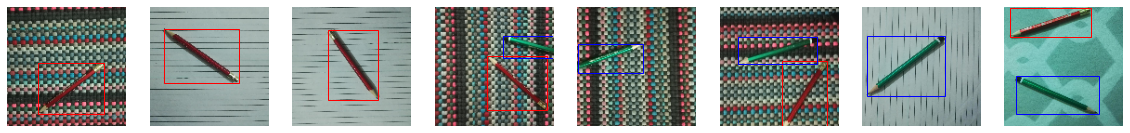

In [ ]:
plot_images(train_iter, 8)

### Valid Samples

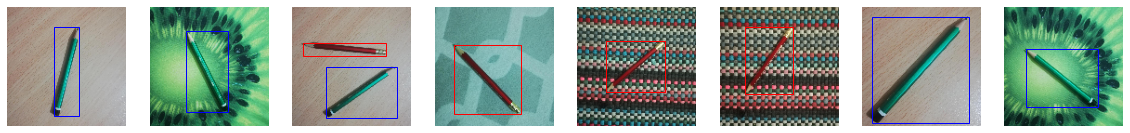

In [ ]:
plot_images(valid_iter, 8)

### Test Samples

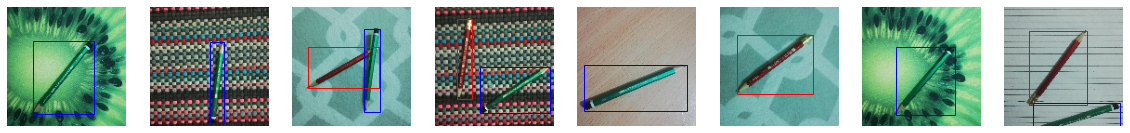

In [ ]:
plot_images(test_iter, 8)

### Model Initialization

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

### Train Function

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  total_loss = 0.0
  model.train()

  for batch_idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    x, y = x.float(), y.float()

    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (total_loss / len(loader))

### Validation Function

In [ ]:
def valid_fn(loader, model, loss_fn):
  total_loss = 0.0
  model.eval()

  with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(loader):
      x, y = x.to(DEVICE), y.to(DEVICE)

      pred_y = model(x)
      total_loss += loss_fn(pred_y, y).item()
    
    return (total_loss / len(loader))

### Training

In [ ]:
train_y, valid_y = [], []
min_loss = 100.0

for i in range(NUM_EPOCHS):
  loss = train_fn(train_loader, model, optimizer, criterion)
  train_y.append(loss)

  vloss = valid_fn(valid_loader, model, criterion)
  valid_y.append(vloss)
  
  print('{0}.loss: {1:.4f}    vloss: {2:.4f}'.format(i + 1, loss, vloss))

  if (vloss < min_loss):
    min_loss = vloss
    torch.save(model.state_dict(), 'model.data')

1.loss: 0.0799    vloss: 0.0586
2.loss: 0.0567    vloss: 0.0562
3.loss: 0.0463    vloss: 0.0610
4.loss: 0.0406    vloss: 0.0406
5.loss: 0.0335    vloss: 0.0366
6.loss: 0.0340    vloss: 0.0331
7.loss: 0.0290    vloss: 0.0286
8.loss: 0.0263    vloss: 0.0276
9.loss: 0.0275    vloss: 0.0268
10.loss: 0.0205    vloss: 0.0192
11.loss: 0.0207    vloss: 0.0172
12.loss: 0.0199    vloss: 0.0258
13.loss: 0.0188    vloss: 0.0188
14.loss: 0.0165    vloss: 0.0134
15.loss: 0.0152    vloss: 0.0165
16.loss: 0.0164    vloss: 0.0160
17.loss: 0.0135    vloss: 0.0148
18.loss: 0.0138    vloss: 0.0106
19.loss: 0.0129    vloss: 0.0114
20.loss: 0.0113    vloss: 0.0076
21.loss: 0.0113    vloss: 0.0112
22.loss: 0.0113    vloss: 0.0088
23.loss: 0.0097    vloss: 0.0076
24.loss: 0.0091    vloss: 0.0103
25.loss: 0.0125    vloss: 0.0106
26.loss: 0.0099    vloss: 0.0061
27.loss: 0.0089    vloss: 0.0074
28.loss: 0.0107    vloss: 0.0078
29.loss: 0.0090    vloss: 0.0056
30.loss: 0.0083    vloss: 0.0080
31.loss: 0.0071    

### Loss Graph

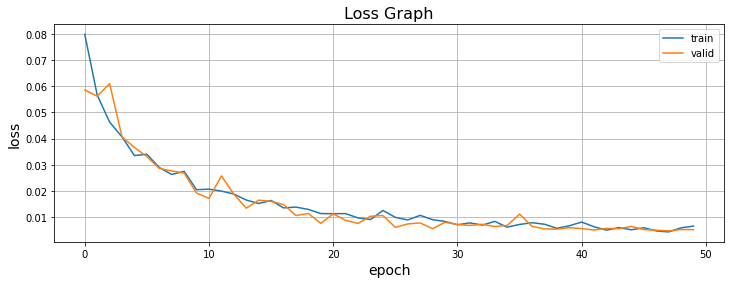

In [ ]:
plt.rcParams["figure.figsize"] = (12, 4)

plt.title('Loss Graph', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.plot(train_y)
plt.plot(valid_y)
plt.legend(['train', 'valid'])
plt.grid()

plt.show()

### Plot Function

In [ ]:
def plot_predictions(data_iter, model, n_samples, threshold):
  imgs, targets = next(data_iter)

  model.eval()
  with torch.no_grad():
    preds = model(imgs.to(DEVICE)).to('cpu')

  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, pred, ax in zip(imgs, preds, axes):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

    anchor = pred[0:4]
    if any(anchor[[0, 1, 2, 3]] > threshold):
          ax.add_patch(patches.Rectangle((anchor[0] * img.shape[1], anchor[1] * img.shape[2]), 
                                         anchor[2] * img.shape[1], 
                                         anchor[3] * img.shape[2], 
                                         linewidth=1, edgecolor='r', facecolor='none'))
          
    anchor = pred[4:8]
    if any(anchor[[0, 1, 2, 3]] > threshold):
          ax.add_patch(patches.Rectangle((anchor[0] * img.shape[1], anchor[1] * img.shape[2]), 
                                         anchor[2] * img.shape[1], 
                                         anchor[3] * img.shape[2], 
                                         linewidth=1, edgecolor='b', facecolor='none'))

### Testing

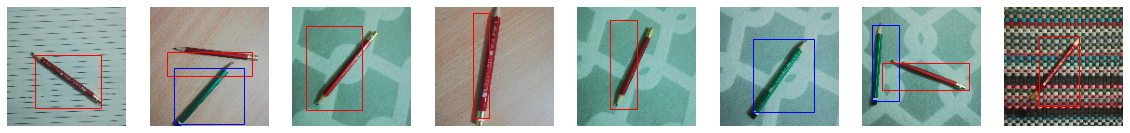

In [ ]:
plot_predictions(test_iter, model, 8, 0.2)